Outliers  0
Adjusted  0
median x-axis:  98.95
median y-axis:  99.0
median agg:  99.0


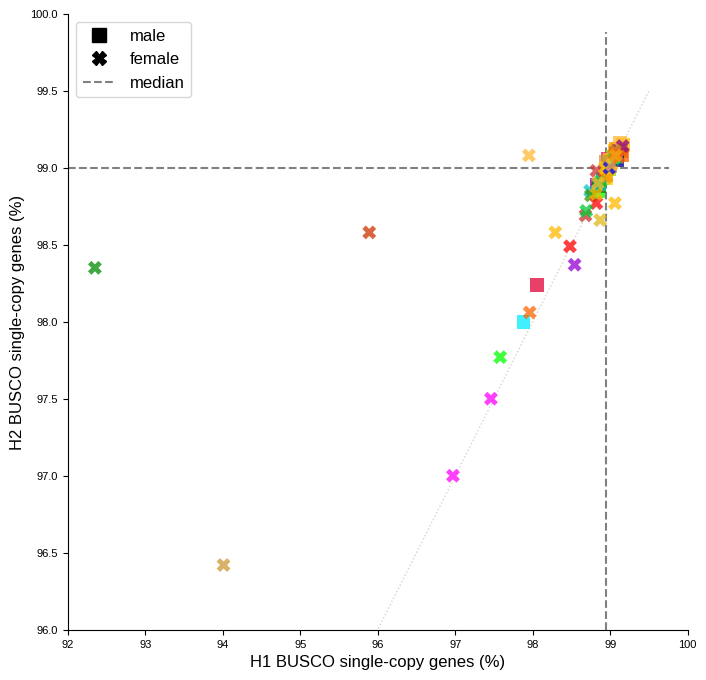

In [2]:
import pathlib
import pandas as pd
import statistics

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import numpy as np

%cd -q "/home/ebertp/work/code/cubi/project-run-hgsvc-hybrid-assemblies/notebooks"
_PROJECT_CONFIG_NB = str(pathlib.Path("00_project_config.ipynb").resolve(strict=True))
_PLOT_CONFIG_NB = str(pathlib.Path("05_plot_config.ipynb").resolve(strict=True))
_ASSM_STATS_NB = str(pathlib.Path("10_assm_stats.ipynb").resolve(strict=True))

%run $_PROJECT_CONFIG_NB
%run $_PLOT_CONFIG_NB
%run $_ASSM_STATS_NB

_MYNAME="plot-busco-scores"
_MYSTAMP=get_nb_stamp(_MYNAME)

_MY_OUT_PATH = PLOT_OUT_MAIN_FIG1.joinpath("panels")

show_assm = "verkko"

if show_assm == "verkko":
    table_file = PROJECT_DATA_ROOT.joinpath("2024_busco/busco-summary.hgsvc3-verkko.tsv")
    sample_suffix = "vrk-ps-sseq"
    cache_file = PROJECT_NB_CACHE.joinpath(
        f"compleasm-verkko.cache.tsv.gz"
    )
if show_assm == "hifiasm":
    table_file = PROJECT_DATA_ROOT.joinpath("2024_busco/busco-summary.hifiasm-hgsvc3.tsv")
    sample_suffix = "hsm-ps-sseq"
    cache_file = PROJECT_NB_CACHE.joinpath(
        f"compleasm-hifiasm.cache.tsv.gz"
    )

# 2024-06-05: no longer needed for cached data
#df = pd.read_csv(table_file, sep="\t", header=0)
#df = df.loc[df["odb_name"] == "primates_odb10", :].copy()

df = pd.read_csv(cache_file, sep="\t", header=0, skiprows=1)
df.rename({"sample": "assembly"}, axis=1, inplace=True)
df["sample"] = df["assembly"].apply(lambda x: x.split(".",1)[0])

def prepare_data_points(visualize):

    main_bars = []
    add_bars = []
    colors = []
    labels = []

    hap1_scores = []
    hap2_scores = []
    un_hap1_scores = []
    un_hap2_scores = []
   
    for sample in HGSVC_FEMALES + HGSVC_MALES:
    
        stats = df.loc[df["sample"] == f"{sample}.{sample_suffix}", :]
        
        stat_h1 = stats.loc[stats["asm_unit"] == "asm-hap1", "singleton_pct"].values[0]
        stat_h2 = stats.loc[stats["asm_unit"] == "asm-hap2", "singleton_pct"].values[0]
        if show_assm == "verkko":
            stat_un = stats.loc[stats["asm_unit"] == "asm-unassigned", "singleton_pct"].values[0]
    
        main_bars.append(stat_h1)
        main_bars.append(stat_h2)
        hap1_scores.append(stat_h1)
        hap2_scores.append(stat_h2)
        if show_assm == "verkko":
            if stat_h1 > stat_h2:
                add_bars.append(0)
                add_bars.append(stat_un)
                un_hap1_scores.append(stat_h1)
                un_hap2_scores.append(stat_h2 + stat_un)
            else:
                add_bars.append(stat_un)
                add_bars.append(0)
                un_hap1_scores.append(stat_h1 + stat_un)
                un_hap2_scores.append(stat_h2)
        colors.append("skyblue")
        colors.append("dodgerblue")
        labels.append(sample.split(".")[0])

    print(show_assm, np.median(np.array(main_bars, dtype=float)))
    print(show_assm, np.mean(np.array(main_bars, dtype=float)))

    if visualize == "barchart":
        ret_values = main_bars, add_bars, colors, labels
    elif visualize == "scatter":
        ret_values = hap1_scores, hap2_scores, un_hap1_scores, un_hap2_scores
    else:
        raise ValueError(f"Unknown visualization type: {visualize}")

    return ret_values   


def plot_busco_scatter(ax):

    select_female = df["sample"].isin(HGSVC_FEMALES)
    hap1_scores = df.loc[((df["asm_unit"] == "hap1") & select_female), "single_pct"].values
    hap2_scores = df.loc[((df["asm_unit"] == "hap2") & select_female), "single_pct"].values
    
    ax.scatter(
        hap1_scores,
        hap2_scores,
        c="grey",
        label="female",
        marker=FEMALE_MARKER,
        alpha=0.5
    )

    select_male = df["sample"].isin(HGSVC_MALES)
    hap1_scores = df.loc[((df["asm_unit"] == "hap1") & select_male), "single_pct"].values
    hap2_scores = df.loc[((df["asm_unit"] == "hap2") & select_male), "single_pct"].values
    
    ax.scatter(
        hap1_scores,
        hap2_scores,
        c="darkgrey",
        label="male",
        marker=MALE_MARKER,
        alpha=0.5
    )

    outlier_hap1 = []
    outlier_hap2 = []
    for sample, stats in df.groupby("sample"):
        hap1 = stats.loc[stats["asm_unit"] == "hap1", "single_pct"].iloc[0]
        hap2 = stats.loc[stats["asm_unit"] == "hap2", "single_pct"].iloc[0]
        abs_diff = abs(hap1 - hap2)
        if abs_diff < 1.:
            continue
        add_un = stats.loc[stats["asm_unit"] == "unassigned", "single_pct"].iloc[0]
        arr_start_x = hap1
        arr_start_y = hap2

        if hap1 > hap2:
            delta_hap1 = 0
            delta_hap2 = add_un
        elif hap2 > hap1:
            delta_hap1 = add_un
            delta_hap2 = 0
        else:
            raise
        outlier_hap1.append(hap1 + delta_hap1)
        outlier_hap2.append(hap2 + delta_hap2)
        
        ax.arrow(
            hap1, hap2, delta_hap1, delta_hap2,
            length_includes_head=True,
            color="lightgrey", zorder=0
        )

    ax.scatter(
        outlier_hap1,
        outlier_hap2,
        c="lightblue",
        label="plus un.",
        marker=GENERIC_MARKER,
        alpha=0.75
    )
    
    ax.legend(loc="lower right")

    ax.plot(
        np.arange(0,100.5),
        np.arange(0,100.5),
        ls="dotted",
        lw=1,
        c="lightgrey",
    )
    
    ax.set_xlim(96.5,100.1)
    ax.set_ylim(96.5,100.1)

    ax.set_xlabel("BUSCO single-copy genes (%) / haplotype 1")
    ax.set_ylabel("BUSCO single-copy genes (%) / haplotype 2")
        
    return ax


def plot_busco_restricted_scatter(ax):

    num_outliers = 0
    num_adjusted = 0
    outlier_scores = []
    male = {"x": [], "y": [], "color": []}
    female = {"x": [], "y": [], "color": []}
    
    threshold = 90
    #threshold = 98
    
    for sample, sample_stats in df.groupby("sample"):

        is_male = (sample_stats["karyotype"] == "male").any()
        #color = "grey" if is_male else "silver"
        color = get_pop_color(sample)
        collector = male if is_male else female

        hap1_score = sample_stats.loc[sample_stats["asm_unit"] == "hap1", "single_pct"].iloc[0]
        hap1_miss = sample_stats.loc[sample_stats["asm_unit"] == "hap1", "missing_pct"].iloc[0]
        hap2_score = sample_stats.loc[sample_stats["asm_unit"] == "hap2", "single_pct"].iloc[0]
        hap2_miss = sample_stats.loc[sample_stats["asm_unit"] == "hap2", "missing_pct"].iloc[0]
        un_score = sample_stats.loc[sample_stats["asm_unit"] == "unassigned", "single_pct"].iloc[0]

        if hap1_score > threshold and hap2_score > threshold:
            collector["x"].append(hap1_score)
            collector["y"].append(hap2_score)
            collector["color"].append(color)
        elif abs(hap1_score - hap2_score) > 0.99:
            print(sample)
            # large difference taken as haploid dropout,
            # fix by adding unassigned
            if hap1_score < hap2_score:
                score1 = hap1_score + max(0, (un_score - hap2_miss))
                score2 = hap2_score
            else:
                score1 = hap1_score
                score2 = hap2_score + max(0, (un_score - hap1_miss))
            if score1 > threshold and score2 > threshold:
                collector["x"].append(score1)
                collector["y"].append(score2)
                collector["color"].append("black")
                num_adjusted += 1
            else:
                num_outliers += 1
                outlier_scores.append(hap1_score)
                outlier_scores.append(hap2_score)
        else:
            num_outliers += 1
            outlier_scores.append(hap1_score)
            outlier_scores.append(hap2_score)

    ax.scatter(
        male["x"],
        male["y"],
        color=male["color"],
        label="male",
        marker=MALE_MARKER,
        alpha=0.75,
        edgecolors="none"
    )

    ax.scatter(
        female["x"],
        female["y"],
        color=female["color"],
        label="female",
        marker=FEMALE_MARKER,
        alpha=0.75,
        edgecolors="none"
    )

    print("Outliers ", num_outliers)
    print("Adjusted ", num_adjusted)
    if num_outliers > 0:
        ax.set_xlim(98,99.5)
        ax.set_ylim(98,99.5)
    else:
        ax.set_xlim(92,100)
        ax.set_ylim(96,100)

    median_x = statistics.median(male["x"] + female["x"])
    print("median x-axis: ", median_x)
    median_y = statistics.median(male["y"] + female["y"])
    print("median y-axis: ", median_y)

    values_all = male["x"] + female["x"] + male["y"] + female["y"]
    print("median agg: ", round(statistics.median(values_all), 1))
    
    ax.axhline(median_y, 0, 0.97, zorder=0, color="grey", ls="dashed")
    ax.axvline(median_x, 0, 0.97, zorder=0, color="grey", ls="dashed")

    ax.plot(
        [90,99.5], [90,99.5],
        lw=1, ls="dotted",
        color="lightgrey", zorder=0
    )

    if num_adjusted > 0:
        legend_handles = get_line_legend(
            [
                {"marker": MALE_MARKER, "color": "darkgrey", "ls": "", "label": "male"},
                {"marker": FEMALE_MARKER, "color": "darkgrey", "ls": "", "label": "female"},
                {"marker": FEMALE_MARKER, "color": "black", "ls": "", "label": "(plus unassigend)"},
            ]
        )
    else:
        legend_handles = get_line_legend(
            [
                {"marker": MALE_MARKER, "color": "black", "ls": "", "label": "male"},
                {"marker": FEMALE_MARKER, "color": "black", "ls": "", "label": "female"},
                {"linestyle": "dashed", "color": "grey", "label": "median"}
            ]
        )

    ax.legend(handles=legend_handles)

    ax.set_xlabel("H1 BUSCO single-copy genes (%)")
    ax.set_ylabel("H2 BUSCO single-copy genes (%)")

    if num_outliers > 0:
        median_outlier_score = sorted(outlier_scores)[len(outlier_scores)//2]
        
        TEXT_BOX = dict(
            boxstyle='round', facecolor='white',
            edgecolor="lightgrey", alpha=0.9
        )
    
        ax.text(
            0.05, 0.9,
            f"Outliers not shown (n={num_outliers})\nmedian score {median_outlier_score}%",
            transform=ax.transAxes,
            fontsize=matplotlib.rcParams["legend.fontsize"],
            bbox=TEXT_BOX
        )

    return ax


def plot_busco_barchart(ax):

    main_bars, add_bars, colors, labels = prepare_data_points("barchart")
    
    bar_positions = np.arange(1, HGSVC_TOTAL*2+1, 1, dtype=float)
    label_positions = np.arange(1.5, HGSVC_TOTAL*2+0.5, 2, dtype=float)
    
    ax.bar(
        bar_positions,
        main_bars,
        width=0.7,
        align="center",
        color=colors
    )
    
    if show_assm == "verkko":
        ax.bar(
            bar_positions,
            add_bars,
            width=0.7,
            align="center",
            bottom=main_bars,
            color="orange"
        )
    
    ax.set_xticks(label_positions)
    ax.set_xticklabels(labels, rotation=90)
            
    ax.set_xlabel("Sample")
    ax.set_ylabel("BUSCO single-copy genes (%)")
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    if show_assm == "verkko":
        ax.set_ylim(90,101)
        ax.set_xlim(0.25, 131.5)
    
        ax.set_yticks([90, 92, 94, 96, 98, 100])
        ax.set_yticklabels([0, 92, 94, 96, 98, 100])
        
        rect = patch.Rectangle(
            (-1,90.5), 132, 0.5,
            zorder=3
        )
        rect.set_facecolor("white")
        rect.set_edgecolor("lightgrey")
        
        ax.add_artist(rect)
        
        ax.annotate(text="", xy=(50, 101), xytext=(90, 101), arrowprops=dict(arrowstyle="<->"), zorder=3)
        ax.text(50, 100.5, s="female")
        ax.text(85, 100.5, s="male")
        ax.axvline(70.5, 0.85, 1, ls="dashed", lw=2, color="gray")
    
        leg = build_patch_legend([("H1", "skyblue"), ("H2", "dodgerblue"), ("Un", "orange")])
        ax.legend(handles=leg, ncol=2, bbox_to_anchor=(0.7, 0.84))
    
    if show_assm == "hifiasm":
        ax.set_ylim(73,101)
        ax.set_xlim(0.25, 131.5)
    
        ax.set_yticks([73, 75, 80, 85, 90, 95, 100])
        ax.set_yticklabels([0, 75, 80, 85, 90, 95, 100])
        
        rect = patch.Rectangle(
            (-1,74), 132, 0.5,
            zorder=3
        )
        rect.set_facecolor("white")
        rect.set_edgecolor("lightgrey")
        
        ax.add_artist(rect)
        
        ax.annotate(text="", xy=(50, 101), xytext=(90, 101), arrowprops=dict(arrowstyle="<->"), zorder=3)
        ax.text(43, 100.5, s="female", fontdict={"fontsize": 8})
        ax.text(90, 100.5, s="male", fontdict={"fontsize": 8})
        ax.axvline(70.5, 0.9, 1, ls="dashed", lw=2, color="gray")
    
        leg = build_patch_legend([("H1", "skyblue"), ("H2", "dodgerblue")])
        ax.legend(handles=leg, ncol=2, bbox_to_anchor=(0.72, 0.93))
    return ax


def create_busco_panel(skip_save=False):

    fig, ax = plt.subplots(figsize=(8,8))

    #ax = plot_busco_scatter(ax)
    ax = plot_busco_restricted_scatter(ax)
    if not skip_save:
        for ext in DEFAULT_PLOT_EXT:
            out_path = _MY_OUT_PATH.joinpath(f"fig1_panel_busco.{ext}")
            save_figure(out_path, fig)
            # pass
        plt.close()
    return plot_busco_restricted_scatter


get_busco_panel = create_busco_panel(True)